In [20]:
import numpy as np
from scipy.integrate import odeint
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.integrate import quad
from functools import partial
import matplotlib.pyplot as plt

import camb
from camb import model, initialpower
print('CAMB version: %s '%camb.__version__)

#plt.style.use('classic')
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
import sys, platform, os
try:
    from cobaya.run import run
except ImportError:
    sys.path.insert(0,'../../cobaya')
    from cobaya.run import run

CAMB version: 1.3.2 


In [21]:
class ro_m_ro_d:
    def __init__(self, b, alpha, w0, oc0h2, M, H0):
        self.b     = b
        self.alpha = alpha
        self.w0    = w0
        self.oc0h2   = oc0h2
        self.H0    = H0
        self.M     = M
        #self.okH0  = self.H0 * np.sqrt(np.abs(self.om0 + self.od0 - 1)) / 3e5
        self.on0 = 0.0014
        #self.ob0h2 = ob0h2
        self.ob0h2 = 0.022383
        self.od0   = 1. - (self.oc0h2*((100./self.H0)**2.) + self.ob0h2*((100./self.H0)**2.) + self.on0)
        self.z     = np.logspace(-2,0.3,100)
        self.omega = odeint(ro_m_ro_d.con, [self.oc0h2*((100./self.H0)**2.), self.od0, self.ob0h2*((100./self.H0)**2.)], self.z, args=(self.b, self.alpha, self.w0))
        
    def con(y, z, b, alpha, w0):
        ro_c , ro_d, ro_b = y
        dydz = [(-1./(1.+z))*(-3.*ro_c+b*(ro_c+ro_d)) , (1./(1.+z))*(b*(ro_c+ro_d)+(1.+w0/(1.+z)**alpha)*3.*ro_d) ,
                3.*ro_b/(1.+z)]
        return dydz
    
    def roc(self,x):
        A = interp1d(self.z, self.omega[:,0],kind='cubic',fill_value="extrapolate")
        return A(x)
    
    def rod(self,x):
        A = interp1d(self.z, self.omega[:,1],kind='cubic',fill_value="extrapolate")
        return A(x)
    
    def rob(self,x):
        A = interp1d(self.z, self.omega[:,2],kind='cubic',fill_value="extrapolate")
        return A(x)
    
    def H(self,x):
        return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))
    
    def dco(self,x): #comoving distance (Mpc)
        a        = np.zeros(len(x))
        for i in range(len(x)):
            zs = int(x[i]/0.004)
            xs   = np.linspace(0,x[i],zs)
            a[i] = np.trapz(3e5/ro_m_ro_d.H(self,xs) , xs )
        return a 

    def dlu(self,x): #luminosity distance (Mpc)        
            return (1.+x)*ro_m_ro_d.dco(self,x)
    
    def mod(self,x): #distance modulus, (apparent magnitude) #data series 1
        return 5.*np.log10(ro_m_ro_d.dlu(self,x)) + 25.0 - self.M
    
    def mu(self,x,m): #data series 1
        return np.array([ro_m_ro_d.mod(self,x) - m])

    def mut(self,x,m): #data series 1
        return np.reshape(ro_m_ro_d.mu(self,x,m),(40,1))

    def chi2(self,x,m,cinv): #data series 1
        return np.matmul(ro_m_ro_d.mu(self,x,m),np.matmul(cinv,ro_m_ro_d.mut(self,x,m)))
    
    def modloglike(self,x,m,c): #data series 1
        cinv = np.linalg.inv(c)
        return - 0.5 * ro_m_ro_d.chi2(self,x,m,cinv)
    
    def desmut(self,x,m): #data series 10
        return np.reshape(ro_m_ro_d.mu(self,x,m),(20,1))

    def deschi2(self,x,m,cinv): #data series 10
        return np.matmul(ro_m_ro_d.mu(self,x,m),np.matmul(cinv,ro_m_ro_d.desmut(self,x,m)))
    
    def desloglike (self,x,m,c): #data series 10
        cinv = np.linalg.inv(c)
        return - 0.5 * ro_m_ro_d.deschi2(self,x,m,cinv)
    
    def dratio(self,x): #data seroies 2 
        rs =(55.154*np.exp(-72.3*(self.on0*(self.H0/100.)**2.+0.0006)**2.))/((self.ob0h2)**0.12807*(self.ob0h2+self.oc0h2)**0.25351)
        #rsfid = 147.78
        return rs*(3e5*x*(ro_m_ro_d.dco(self,x))**2./ro_m_ro_d.H(self,x))**(-1./3.)
    
    def bao(self, x, dv): #data series 2
        return np.array(ro_m_ro_d.dratio(self,x) - dv)  #((3e5*x*dm**2.)/h)**(1./3.))

    def baot(self, x, dv): #data series 2
        return np.reshape(ro_m_ro_d.bao(self, x, dv),(6,1))
    
    def baochi2(self, x, dv, cinv): #data series 2
        return np.matmul(ro_m_ro_d.bao(self,x,dv),np.matmul(cinv,ro_m_ro_d.baot(self,x,dv)))
    
    def baologlike(self,x,dv, c): #data series 2
        coinv = np.linalg.inv(c)
        return -0.5*ro_m_ro_d.baochi2(self, x, dv, coinv)

    def baohdc(self, x, d1, d2): #H(z) , d_comoving - data series 3
        rs =(55.154*np.exp(-72.3*(self.on0*(self.H0/100.)**2.+0.0006)**2.))/((self.ob0h2)**0.12807*(self.ob0h2+self.oc0h2)**0.25351)
        rsfid = 147.78
        return np.append(np.array(rsfid*ro_m_ro_d.dco(self,x)/rs - d1), np.array(rsfid*ro_m_ro_d.H(self,x)/rs - d2)) 

    def baothdc(self, x, h, dc): #data series 3
        return np.reshape(ro_m_ro_d.baohdc(self, x, h, dc),(6,1)) 
    
    def baohdcchi2(self, x, h, dc, cinv):  #data series 3
        return np.matmul(ro_m_ro_d.baohdc(self,x,h, dc),np.matmul(cinv,ro_m_ro_d.baothdc(self, x, h, dc)))
    
    def baohdcloglike(self,x, h, dc, c):  #data series 3
        coinv = np.linalg.inv(c)
        return -0.5*ro_m_ro_d.baohdcchi2(self, x, h, dc, coinv)
      
    def dratioinv(self,x): #data series 4
        rs =(55.154*np.exp(-72.3*(self.on0*(self.H0/100.)**2.+0.0006)**2.))/((self.ob0h2)**0.12807*(self.ob0h2+self.oc0h2)**0.25351)
        rsfid = 147.78
        return rsfid*((3e5*x*(ro_m_ro_d.dco(self,x))**2./ro_m_ro_d.H(self,x))**(1./3.))/rs
    
    def dratioinvloglike(self, x, y, yerr): #data series 4
        sigma2 = yerr ** 2. 
        return -0.5 * np.sum((y - ro_m_ro_d.dratioinv(self,x)) ** 2 / (sigma2))
 
    def da(self,x): #data series 4'
        rs =(55.154*np.exp(-72.3*(self.on0*(self.H0/100.)**2.+0.0006)**2.))/((self.ob0h2)**0.12807*(self.ob0h2+self.oc0h2)**0.25351)
        return ro_m_ro_d.dco(self,x)/(rs*(1+x))
    
    def daloglike(self, x, y, yerr): #data series 4'
        sigma2 = yerr ** 2. 
        return -0.5 * np.sum((y - ro_m_ro_d.da(self,x)) ** 2 / (sigma2))
    
    def dcdh(self, x, d1, d2): #data series 5
        rs =(55.154*np.exp(-72.3*(self.on0*(self.H0/100.)**2.+0.0006)**2.))/((self.ob0h2)**0.12807*(self.ob0h2+self.oc0h2)**0.25351)
        return np.append(np.array(ro_m_ro_d.dco(self,x)/rs - d1), np.array(3e5/(ro_m_ro_d.H(self,x)*rs) - d2))
    
    def dcdht(self, x, d1, d2): #data seies 5
        return np.reshape(ro_m_ro_d.dcdh(self, x, d1, d2),(2,1)) 
    
    def dcdhchi2(self, x, d1, d2, cinv):#data seies 5
        return np.matmul(ro_m_ro_d.dcdh(self, x, d1, d2),np.matmul(cinv,ro_m_ro_d.dcdht(self, x, d1, d2)))
    
    def dcdhloglike(self, x, d1, d2, c): #data seies 5
        coinv = np.linalg.inv(c)
        return -0.5*ro_m_ro_d.dcdhchi2(self, x, d1, d2, coinv)
    
    def hloglike(self, x, y, yerr): #data series 6
        sigma2 = yerr ** 2. 
        return -0.5 * np.sum((y - ro_m_ro_d.H(self,x)) ** 2 / (sigma2))
    
    def grbloglike(self, x, y, err): #data series 7
        sigma2 = err ** 2. 
        return -0.5 * np.sum((y - (ro_m_ro_d.mod(self,x) + self.M)) ** 2 / (sigma2))
    
    def qsologlike(self, x, y, err): #data series 8
        sigma2 = err ** 2. 
        return -0.5 * np.sum((y - (6.*11.03e3/(29.1*ro_m_ro_d.dco(self,x)/(1.+x)))) ** 2 / (sigma2))
    def angularscale(self, x):
        rs =(55.154*np.exp(-72.3*(self.on0*(self.H0/100.)**2.+0.0006)**2.))/((self.ob0h2)**0.12807*(self.ob0h2+self.oc0h2)**0.25351)
        return rs/ro_m_ro_d.dco(self,x)
    
    def angularscaleloglike(self, x, y, yerr):
        sigma2 = yerr ** 2. 
        return -0.5 * np.sum((y - ro_m_ro_d.angularscale(self,x)) ** 2 / (sigma2))
    

In [23]:
#Pantheon data - data series 1
data = np.loadtxt('./pantheon-bin40.txt',usecols=(1,4,5),
                  dtype=[('z','f8'),('m','f8'),('e','f8')])
z1 = data['z']
mu = data['m']
c1    = np.loadtxt('./pantheon-cov40.txt').reshape(40,40) #cov matrix
e1    = np.diag(data['e']**2) #errors
co1 = c1 + e1

#BAO data from https://arxiv.org/pdf/2101.08817.pdf - last 2 correlated ones - data series 5
z5 = np.array([2.334])
dc = np.array([37.5])
dh = np.array([8.99])
c5 = np.array([[1.3225, -0.1009], [-0.1009, 0.038]])


#H(z) data from OHD - data series 6
z6 = np.array([0.0708, 0.09, 0.12, 0.17, 0.179, 0.199, 0.2, 0.240, 0.27, 0.28, 0.35, 0.352, 0.3802,
               0.4, 0.4004, 0.4247, 0.43, 0.44, 0.4497, 0.47, 0.4783, 0.48, 0.57, 0.593, 0.6, 0.68,
               0.73, 0.781, 0.875, 0.88, 0.9, 1.037, 1.3, 1.363, 1.43, 1.53, 1.75, 1.965, 2.34, 2.36])
y6 = np.array([69.0, 69.0, 68.6, 83.0, 75.0, 75.0, 72.9, 79.69, 77.0, 88.8, 84.4, 83.0, 83.0, 95.0, 77.0,
              87.1, 86.45, 82.6, 92.8, 89.0, 80.9, 97.0, 92.4, 104.0, 87.9, 92.0, 97.3, 105.0, 125.0,
              90.0, 117.0, 154.0, 168.0, 160.0, 177.0, 140.0, 202.0, 186.5, 222.0, 226.0])
yerr6 = np.array([19.68, 12.0, 26.2, 8.0, 4.0, 5.0, 29.6, 2.65, 14.0, 36.6, 7.0, 14.0, 13.5, 17.0, 10.2, 11.2,
                 3.68, 7.8, 12.9, 50.0, 9.0, 62.0, 4.5, 13.0, 6.1, 8.0, 7.0, 12.0, 17.0, 40.0, 23.0, 20.0,
                 17.0, 33.6, 18.0, 14.0, 40.0, 50.4, 7.0, 8.0])


#GRB - Distance modulus data from https://iopscience.iop.org/article/10.3847/1538-4357/ab4e11#apjab4e11eqn5 - data series 7
#data7 = np.loadtxt('./grb-25.txt',usecols=(2, 3, 4, 7, 8, 9, 10),
                  #dtype=[('z','f8'),('Ep','f8'),('eEp','f8'),('sb','f8'),('esb','f8'),('miu','f8'), ('emiu','f8')])
#z7 = np.array(data7['z'])
#y7 = np.array(data7['miu'])
#err7 = (2.5**2.*((0.16*np.log10(np.array(data7['Ep'])/550.))**2.
        #+((1.15/np.log(10.))*(np.array(data7['eEp']))/(np.array(data7['Ep'])))**2.+0.07**2.+0.41**2.)+
        #((2.5/np.log(10.))*((np.array(data7['esb']))/(np.array(data7['sb']))))**2.)**0.5
        
z7 = np.array([3.51,  2.53,  1.406,1.17,  0.807, 2.06,  1.758, 2.33,  0.6439,2.4,
               2.49,  0.3399,2.2,   3.512, 1.567, 1.368, 1.063, 0.49,  0.8969,2.1062,
               1.822, 0.544, 0.736, 3.57,  4.35 ])
y7 = np.array([46.22,45.49,43.25,46.89,45.05,46.61,45.22,46.48,42.73,46.35,45.86,41.56,
               44.78,48.94,44.61,45.19,45.63,42.55,45.43,44.47,44.66,43.3, 45.14,46.12,0.24])

err7 = np.array([1.05339617e+00,1.06831447e+00,1.05576995e+00,1.21090833e+00,
                 1.07677033e+00,1.07478533e+00,1.04498858e+00,1.05208452e+00,
                 1.04226657e+00,1.04844845e+00,1.05662548e+00,1.04581157e+00,
                 1.04932820e+00,1.15159609e+00,1.04233645e+00,1.05226820e+00,
                 1.06303003e+00,1.10934408e+00,1.04398968e+00,1.04307771e+00,
                 1.06649153e+00,1.05048751e+00,1.05271612e+00,1.06845839e+00,5.78838579e+04])


#QSO data - angular size - data series 8
#ata8 = np.loadtxt('./QSO.txt',usecols=(2, 3, 4, 10, 11, 12),
                  #type=[('z1','f8'),('d1','f8'),('e1','f8'),('z2','f8'),('d2','f8'),('e2','f8')])
#z8 = np.array(np.append(data8['z1'],data8['z2']))
#8 = np.array(np.append(data8['d1'],data8['d2']))
#8 = np.array(np.append(data8['e1'],data8['e2']))

e8 = np.array([0.027, 0.052, 0.077, 0.048, 0.077, 0.097, 0.041, 0.15 , 0.108,
               0.208, 0.11 , 0.075, 2.6  , 1.3  , 1.8  , 0.076, 0.058, 0.304,
               0.144, 0.094, 0.183, 0.049, 0.249, 0.059, 0.041, 0.087, 0.121,
               0.063, 0.426, 0.051, 0.033, 0.081, 0.197, 0.122, 0.163, 0.453,
               0.07 , 0.16 , 0.258, 0.581, 0.086, 0.053, 0.054, 0.069, 0.048,
               0.089, 0.081, 0.088, 0.085, 0.147, 0.064, 1.   , 0.111, 0.19 ,
               0.381, 0.146, 0.111, 0.107, 0.77 , 0.187, 0.047, 0.064, 0.064,
               0.135, 0.863, 0.117, 0.058, 0.096, 0.14 , 0.171, 0.114, 0.306,
               1.19 , 0.725, 0.682, 0.223, 0.19 , 0.059, 0.082, 0.059, 0.429,
               0.216, 0.109, 0.168, 0.1  , 0.081, 0.034, 0.051, 0.203, 0.093,
               0.214, 0.108, 0.124, 0.205, 0.139, 0.191, 0.15 , 0.047, 0.082,
               0.495, 0.9  , 0.286, 1.17 , 0.7  , 0.163, 0.094, 0.279, 0.148,
               0.057, 0.368, 0.132, 0.5  , 0.048, 0.077, 0.223, 0.036, 0.045,
               0.323, 0.101, 0.132])
d8 = np.array([2.743, 1.454, 1.049, 1.974, 2.399, 1.933, 1.525, 1.762, 2.218,
               1.292, 1.972, 1.904, 0.129, 0.245, 0.074, 1.139, 1.518, 0.897,
               1.953, 1.758, 1.73 , 2.094, 1.635, 1.144, 1.149, 1.747, 1.661,
               1.81 , 0.568, 1.031, 1.517, 1.794, 1.544, 1.552, 1.797, 1.155,
               0.76 , 1.529, 1.399, 0.88 , 1.638, 1.727, 1.758, 1.277, 1.485,
               1.611, 1.099, 1.254, 2.622, 2.032, 1.38 , 0.151, 2.109, 1.544,
               1.046, 1.883, 0.979, 1.583, 0.517, 1.2  , 2.07 , 1.387, 1.682,
               0.528, 0.438, 1.608, 1.46 , 1.168, 0.758, 0.596, 0.424, 1.481,
               0.074, 0.168, 0.073, 1.484, 1.327, 1.784, 1.292, 1.243, 0.87 ,
               2.446, 1.038, 0.796, 1.497, 1.743, 1.788, 1.788, 0.659, 1.431,
               1.245, 1.005, 1.464, 1.602, 1.629, 1.25 , 0.66 , 1.136, 0.518,
               0.85 , 0.307, 1.13 , 0.059, 0.194, 1.526, 1.207, 1.7  , 1.901,
               1.595, 1.422, 1.916, 0.664, 2.264, 1.449, 1.097, 1.434, 1.676,
               1.598, 1.506, 1.252])
z8 = np.array([0.462 , 0.5362, 0.539 , 0.558 , 0.574 , 0.591 , 0.5928, 0.632 ,
               0.67  , 0.6715, 0.673 , 0.677 , 1.244 , 1.454 , 1.415 , 0.74  ,
               0.752 , 0.819 , 0.846 , 0.847 , 0.857 , 0.858 , 0.871 , 0.888 ,
               0.894 , 0.947 , 0.96  , 0.965 , 0.978 , 0.999 , 1.016 , 1.018 ,
               1.02  , 1.025 , 1.034 , 1.066 , 1.07  , 1.08  , 1.088 , 1.0987,
               1.139 , 1.141 , 1.153 , 1.159 , 1.184 , 1.187 , 1.202 , 1.212 ,
               1.216 , 1.22  , 1.244 , 2.44  , 1.252 , 1.254 , 1.275 , 1.278 ,
               1.285 , 1.29  , 1.292 , 1.296 , 1.299 , 1.302 , 1.319 , 1.323 ,
               1.326 , 1.339 , 1.356 , 1.4   , 1.407 , 1.41  , 1.417 , 1.42  ,
               1.172 , 1.81  , 1.718 , 1.472 , 1.476 , 1.479 , 1.489 , 1.49  ,
               1.492 , 1.5586, 1.5595, 1.563 , 1.57  , 1.598 , 1.6077, 1.6301,
               1.633 , 1.646 , 1.66  , 1.72  , 1.74  , 1.751 , 1.763 , 1.774 ,
               1.776 , 1.81  , 1.821 , 1.837 , 1.635 , 1.873 , 1.537 , 1.396 ,
               1.939 , 1.975 , 2.025 , 2.048 , 2.055 , 2.073 , 2.09  , 0.564 ,
               2.13  , 2.136 , 2.165 , 2.198 , 2.448 , 2.5584, 2.685 , 2.73  ])
    

#Des data - distance modulus - https://des.ncsa.illinois.edu/releases/sn - data series 10
data10 = np.loadtxt('./des.txt',usecols=(1,4,5),
                  dtype=[('z','f8'),('m','f8'),('e','f8')])
z10 = data10['z']
mu10 = data10['m']
c10    = np.loadtxt('./des-cov.txt')[1:].reshape(20,20) #cov matrix
e10    = np.diag(data10['e']**2) #errors
co10 = c10 + e10

#CMB data - Planck 2018
z11 = 1
theta = 1.04097e-2
yerr11 = 0.00046e-2

              
def my_like(b, alpha, w0, oc0h2, M, H0): 
    obj   = ro_m_ro_d(b, alpha, w0, oc0h2, M, H0)
    return obj.modloglike(z1,mu,co1) + obj.dcdhloglike(z5, dc, dh, c5) + obj.hloglike(z6, y6, yerr6) + obj.desloglike(z10,mu10,co10) + obj.grbloglike(z7, y7, err7) + obj.qsologlike(z8, d8, e8)



In [24]:
info = {"likelihood": {"external": my_like},
        "params"    : {
            "oc0h2": {"prior": {"min": 0.001  , "max": 0.4},"ref": 0.11 ,"latex": r"\Omega_ch^2"},
            "w0"   : {"prior": {"min": -3.0 , "max": -0.1},"ref": -1. ,"latex": r"w_0"},
            "b"    : {"prior": {"min": 0.0  , "max": 1.0},"ref": 0.2 ,"latex": r"b^2"},
            "alpha": {"prior": {"min": 0.0  , "max": 2.},"ref": 1. ,"latex": r"\alpha"},
            "M"    : {"prior": {"min": 15.0 , "max": 25.},"ref": 20. ,"latex": r"M"},
            "H0"   : {"prior": {"min": 55.0 , "max": 85.},"ref": 69. ,"latex": r"H_0"},
            "om0"  : {"derived": lambda oc0h2, H0: ((oc0h2+0.022383)/((H0/100.)**2.))+0.0014,
                      "latex": r"\Omega_m0"}
                        },
        "sampler": {"mcmc": {"Rminus1_stop": 0.01, "max_tries": 100000}},
        "output":"bao-h-pantheon-des-grb-qso-b/gaus",
        "force":"True"
        }

In [25]:
from cobaya.run import run
updated_info, sampler = run(info)

[output] Output to be read-from/written-into folder 'bao-h-pantheon-des-grb-qso-b', with prefix 'gaus'
[output] Found existing info files with the requested output prefix: 'bao-h-pantheon-des-grb-qso-b/gaus'
[output] Will delete previous products ('force' was requested).
[external] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {external: 2.89}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: oc0h2:0.11, w0:-1, b:0.2, alpha:1, M:20, H0:69
[mcmc] Sampling!
[mcmc] Progress @ 2021-08-13 22:33:12 : 1 steps taken, and 0 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:34:12 : 575 steps taken, and 7 accepted.
[mcmc] Progress @ 2021-08-13 22:35:12 : 1049 steps taken, and 11 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:36:12 : 1663 steps taken, and 14 accepted.
[mcmc] Progress @ 2021-08-13 22:37:13 : 2220 steps taken, and 16 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:38:13 : 2807 steps taken, and 17 accepted.
[mcmc] Progress @ 2021-08-13 22:39:13 : 3438 steps taken, and 17 accepted.
[mcmc] Progress @ 2021-08-13 22:40:13 : 3989 steps taken, and 18 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:41:13 : 4558 steps taken, and 19 accepted.
[mcmc] Progress @ 2021-08-13 22:42:14 : 5143 steps taken, and 20 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:43:14 : 5728 steps taken, and 25 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:44:14 : 6473 steps taken, and 27 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:45:14 : 7171 steps taken, and 28 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:46:14 : 7795 steps taken, and 28 accepted.
[mcmc] Progress @ 2021-08-13 22:47:14 : 8512 steps taken, and 28 accepted.
[mcmc] Progress @ 2021-08-13 22:48:15 : 9241 steps taken, and 31 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:49:15 : 9874 steps taken, and 31 accepted.
[mcmc] Progress @ 2021-08-13 22:50:15 : 10478 steps taken, and 33 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:51:15 : 11166 steps taken, and 34 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:52:16 : 11723 steps taken, and 37 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:53:16 : 12354 steps taken, and 39 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:54:16 : 13020 steps taken, and 41 accepted.
[mcmc] Progress @ 2021-08-13 22:55:16 : 13705 steps taken, and 41 accepted.
[mcmc] Progress @ 2021-08-13 22:56:16 : 14334 steps taken, and 41 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:57:17 : 14961 steps taken, and 45 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 22:58:17 : 15649 steps taken, and 45 accepted.
[mcmc] Progress @ 2021-08-13 22:59:17 : 16339 steps taken, and 48 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:00:17 : 16938 steps taken, and 48 accepted.
[mcmc] Progress @ 2021-08-13 23:01:17 : 17683 steps taken, and 50 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:02:17 : 18474 steps taken, and 50 accepted.
[mcmc] Progress @ 2021-08-13 23:03:18 : 19282 steps taken, and 52 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:04:18 : 19964 steps taken, and 57 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:05:18 : 20672 steps taken, and 59 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:06:18 : 21336 steps taken, and 62 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:07:18 : 21986 steps taken, and 62 accepted.
[mcmc] Progress @ 2021-08-13 23:08:19 : 22586 steps taken, and 63 accepted.
[mcmc] Progress @ 2021-08-13 23:09:19 : 23164 steps taken, and 67 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:10:19 : 23790 steps taken, and 68 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:11:19 : 24407 steps taken, and 71 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:12:19 : 25000 steps taken, and 72 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:13:20 : 25634 steps taken, and 74 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:14:20 : 26428 steps taken, and 74 accepted.
[mcmc] Progress @ 2021-08-13 23:15:20 : 27163 steps taken, and 75 accepted.
[mcmc] Progress @ 2021-08-13 23:16:20 : 27869 steps taken, and 77 accepted.
[mcmc] Progress @ 2021-08-13 23:17:20 : 28589 steps taken, and 77 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:18:21 : 29287 steps taken, and 79 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:19:21 : 29916 steps taken, and 80 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:20:21 : 30538 steps taken, and 83 accepted.
[mcmc] Progress @ 2021-08-13 23:21:21 : 31150 steps taken, and 86 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:22:21 : 31804 steps taken, and 87 accepted.
[mcmc] Progress @ 2021-08-13 23:23:22 : 32510 steps taken, and 89 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:24:22 : 33242 steps taken, and 91 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:25:22 : 34032 steps taken, and 92 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:26:22 : 34743 steps taken, and 94 accepted.
[mcmc] Progress @ 2021-08-13 23:27:22 : 35456 steps taken, and 94 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:28:23 : 36175 steps taken, and 94 accepted.
[mcmc] Progress @ 2021-08-13 23:29:23 : 36902 steps taken, and 95 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:30:23 : 37586 steps taken, and 95 accepted.
[mcmc] Progress @ 2021-08-13 23:31:23 : 38323 steps taken, and 95 accepted.
[mcmc] Progress @ 2021-08-13 23:32:23 : 39078 steps taken, and 98 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:33:23 : 39811 steps taken, and 100 accepted.
[mcmc] Progress @ 2021-08-13 23:34:24 : 40573 steps taken, and 103 accepted.
[mcmc] Progress @ 2021-08-13 23:35:24 : 41403 steps taken, and 104 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:36:24 : 42186 steps taken, and 106 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:37:24 : 42882 steps taken, and 106 accepted.
[mcmc] Progress @ 2021-08-13 23:38:24 : 43670 steps taken, and 106 accepted.
[mcmc] Progress @ 2021-08-13 23:39:25 : 44420 steps taken, and 107 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:40:25 : 45175 steps taken, and 107 accepted.
[mcmc] Progress @ 2021-08-13 23:41:25 : 45917 steps taken, and 108 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:42:25 : 46624 steps taken, and 110 accepted.
[mcmc] Progress @ 2021-08-13 23:43:25 : 47337 steps taken, and 112 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:44:25 : 48156 steps taken, and 115 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:45:25 : 48932 steps taken, and 115 accepted.
[mcmc] Progress @ 2021-08-13 23:46:26 : 49785 steps taken, and 115 accepted.
[mcmc] Progress @ 2021-08-13 23:47:26 : 50522 steps taken, and 115 accepted.
[mcmc] Progress @ 2021-08-13 23:48:26 : 51365 steps taken, and 115 accepted.
[mcmc] Progress @ 2021-08-13 23:49:26 : 52128 steps taken, and 116 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:50:26 : 52849 steps taken, and 116 accepted.
[mcmc] Progress @ 2021-08-13 23:51:26 : 53597 steps taken, and 117 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:52:27 : 54394 steps taken, and 119 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:53:27 : 55168 steps taken, and 120 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:54:27 : 55872 steps taken, and 121 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:55:27 : 56572 steps taken, and 122 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:56:27 : 57393 steps taken, and 123 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:57:28 : 58268 steps taken, and 125 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:58:28 : 59037 steps taken, and 126 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-13 23:59:28 : 59729 steps taken, and 128 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 00:00:28 : 60495 steps taken, and 128 accepted.
[mcmc] Progress @ 2021-08-14 00:01:28 : 61235 steps taken, and 128 accepted.
[mcmc] Progress @ 2021-08-14 00:02:28 : 61971 steps taken, and 131 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 00:03:29 : 62838 steps taken, and 133 accepted.
[mcmc] Progress @ 2021-08-14 00:04:29 : 63653 steps taken, and 134 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 00:05:29 : 64342 steps taken, and 135 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 00:06:29 : 64978 steps taken, and 139 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 00:07:29 : 65717 steps taken, and 139 accepted.
[mcmc] Progress @ 2021-08-14 00:08:29 : 66493 steps taken, and 141 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 00:09:30 : 67193 steps taken, and 142 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 00:10:30 : 67864 steps taken, and 142 accepted.
[mcmc] Progress @ 2021-08-14 00:11:30 : 68591 steps taken, and 142 accepted.
[mcmc] Progress @ 2021-08-14 00:12:30 : 69281 steps taken, and 142 accepted.
[mcmc] Progress @ 2021-08-14 00:13:30 : 69937 steps taken, and 142 accepted.
[mcmc] Progress @ 2021-08-14 00:14:30 : 70565 steps taken, and 143 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 00:15:30 : 71142 steps taken, and 144 accepted.
[mcmc] Progress @ 2021-08-14 03:15:58 : 71412 steps taken, and 144 accepted.
[mcmc] Progress @ 2021-08-14 09:31:12 : 71486 steps taken, and 144 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:32:12 : 71997 steps taken, and 144 accepted.
[mcmc] Progress @ 2021-08-14 09:33:13 : 72601 steps taken, and 144 accepted.
[mcmc] Progress @ 2021-08-14 09:34:13 : 73194 steps taken, and 147 accepted.
[mcmc] Progress @ 2021-08-14 09:35:13 : 73797 steps taken, and 149 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:36:13 : 74423 steps taken, and 150 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:37:13 : 75064 steps taken, and 151 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:38:13 : 75596 steps taken, and 152 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:39:13 : 76154 steps taken, and 152 accepted.
[mcmc] Progress @ 2021-08-14 09:40:13 : 76840 steps taken, and 156 accepted.
[mcmc] Progress @ 2021-08-14 09:41:13 : 77420 steps taken, and 157 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:42:14 : 77986 steps taken, and 160 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:43:14 : 78561 steps taken, and 160 accepted.
[mcmc] Progress @ 2021-08-14 09:44:14 : 79132 steps taken, and 162 accepted.
[mcmc] Progress @ 2021-08-14 09:45:14 : 79774 steps taken, and 164 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:46:15 : 80355 steps taken, and 164 accepted.
[mcmc] Progress @ 2021-08-14 09:47:15 : 80953 steps taken, and 164 accepted.
[mcmc] Progress @ 2021-08-14 09:48:15 : 81580 steps taken, and 164 accepted.
[mcmc] Progress @ 2021-08-14 09:49:15 : 82137 steps taken, and 164 accepted.
[mcmc] Progress @ 2021-08-14 09:50:15 : 82722 steps taken, and 167 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:51:15 : 83361 steps taken, and 167 accepted.
[mcmc] Progress @ 2021-08-14 09:52:15 : 83956 steps taken, and 170 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:53:16 : 84533 steps taken, and 170 accepted.
[mcmc] Progress @ 2021-08-14 09:54:16 : 85129 steps taken, and 172 accepted.
[mcmc] Progress @ 2021-08-14 09:55:16 : 85705 steps taken, and 173 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:56:16 : 86321 steps taken, and 175 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 09:57:16 : 86912 steps taken, and 175 accepted.
[mcmc] Progress @ 2021-08-14 09:58:16 : 87566 steps taken, and 175 accepted.
[mcmc] Progress @ 2021-08-14 09:59:17 : 88168 steps taken, and 177 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:00:17 : 88758 steps taken, and 178 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:01:17 : 89391 steps taken, and 179 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:02:17 : 89968 steps taken, and 179 accepted.
[mcmc] Progress @ 2021-08-14 10:03:17 : 90506 steps taken, and 179 accepted.
[mcmc] Progress @ 2021-08-14 10:04:17 : 91032 steps taken, and 179 accepted.
[mcmc] Progress @ 2021-08-14 10:05:18 : 91665 steps taken, and 179 accepted.
[mcmc] Progress @ 2021-08-14 10:06:18 : 92248 steps taken, and 179 accepted.
[mcmc] Progress @ 2021-08-14 10:07:18 : 92825 steps taken, and 179 accepted.
[mcmc] Progress @ 2021-08-14 10:08:18 : 93469 steps taken, and 179 accepted.
[mcmc] Progress @ 2021-08-14 10:09:18 : 94099 steps taken, and 180 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:10:19 : 94685 steps taken, and 182 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:11:19 : 95323 steps taken, and 182 accepted.
[mcmc] Progress @ 2021-08-14 10:12:19 : 95869 steps taken, and 184 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:13:19 : 96421 steps taken, and 186 accepted.
[mcmc] Progress @ 2021-08-14 10:14:19 : 96921 steps taken, and 186 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:15:20 : 97438 steps taken, and 187 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:16:20 : 98048 steps taken, and 188 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:17:20 : 98733 steps taken, and 189 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:18:20 : 99411 steps taken, and 191 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:19:20 : 99975 steps taken, and 191 accepted.
[mcmc] Progress @ 2021-08-14 10:20:20 : 100641 steps taken, and 192 accepted.
[mcmc] Progress @ 2021-08-14 10:21:21 : 101265 steps taken, and 193 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:22:21 : 101869 steps taken, and 195 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:23:21 : 102529 steps taken, and 195 accepted.
[mcmc] Progress @ 2021-08-14 10:24:21 : 103170 steps taken, and 196 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:25:21 : 103919 steps taken, and 197 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:26:22 : 104510 steps taken, and 198 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:27:22 : 105135 steps taken, and 200 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:28:22 : 105753 steps taken, and 200 accepted.
[mcmc] Progress @ 2021-08-14 10:29:22 : 106362 steps taken, and 200 accepted.
[mcmc] Progress @ 2021-08-14 10:30:23 : 107024 steps taken, and 201 accepted.
[mcmc] Progress @ 2021-08-14 10:31:23 : 107595 steps taken, and 201 accepted.
[mcmc] Progress @ 2021-08-14 10:32:23 : 108255 steps taken, and 201 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:33:23 : 108940 steps taken, and 201 accepted.
[mcmc] Progress @ 2021-08-14 10:34:23 : 109604 steps taken, and 203 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:35:23 : 110216 steps taken, and 203 accepted.
[mcmc] Progress @ 2021-08-14 10:36:23 : 110888 steps taken, and 203 accepted.
[mcmc] Progress @ 2021-08-14 10:37:23 : 111570 steps taken, and 204 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:38:23 : 112182 steps taken, and 206 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:39:24 : 112942 steps taken, and 207 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:40:24 : 113629 steps taken, and 209 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:41:24 : 114324 steps taken, and 212 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:42:24 : 114951 steps taken, and 214 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:43:24 : 115601 steps taken, and 215 accepted.
[mcmc] Progress @ 2021-08-14 10:44:25 : 116216 steps taken, and 216 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:45:25 : 116920 steps taken, and 216 accepted.
[mcmc] Progress @ 2021-08-14 10:46:25 : 117555 steps taken, and 217 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:47:25 : 118220 steps taken, and 218 accepted.
[mcmc] Progress @ 2021-08-14 10:48:25 : 118966 steps taken, and 219 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:49:25 : 119559 steps taken, and 221 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:50:25 : 120230 steps taken, and 221 accepted.
[mcmc] Progress @ 2021-08-14 10:51:25 : 120885 steps taken, and 221 accepted.
[mcmc] Progress @ 2021-08-14 10:52:26 : 121625 steps taken, and 223 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:53:26 : 122304 steps taken, and 225 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:54:26 : 122947 steps taken, and 227 accepted.
[mcmc] Progress @ 2021-08-14 10:55:26 : 123687 steps taken, and 230 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:56:26 : 124369 steps taken, and 231 accepted.
[mcmc] Progress @ 2021-08-14 10:57:26 : 125084 steps taken, and 234 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:58:26 : 125736 steps taken, and 237 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Progress @ 2021-08-14 10:59:26 : 126351 steps taken, and 239 accepted.


<ipython-input-21-1a0682e3a233>:36: RuntimeWarning: invalid value encountered in sqrt
  return self.H0*np.sqrt((ro_m_ro_d.roc(self,x) + ro_m_ro_d.rod(self,x)) + ro_m_ro_d.rob(self,x))


[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.002
[mcmc]  - Convergence of means: R-1 = 12.828598 after 240 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2021-08-14 11:00:27 : 126905 steps taken, and 248 accepted.
[mcmc] Progress @ 2021-08-14 11:01:27 : 127092 steps taken, and 308 accepted.
[mcmc] Progress @ 2021-08-14 11:02:27 : 127281 steps taken, and 366 accepted.
[mcmc] Progress @ 2021-08-14 11:03:27 : 127462 steps taken, and 417 accepted.
[mcmc] Progress @ 2021-08-14 11:04:27 : 127639 steps taken, and 467 accepted.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.004
[mcmc]  - Convergence of means: R-1 = 14.958038 after 480 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2021-08-14 11:05:27 : 127823 steps taken, and 528 accepted.
[mcmc] Progress @ 2021-08-14 11:06:28 : 128008 steps taken, and 603 accepted.
[mcmc] Progress @ 2021-0

KeyboardInterrupt: 

[root] *WARNING* outlier fraction 0.0019345238095238096 
[root] *WARNING* 2D kernel density bandwidth optimizer failed for oc0h2, om0. Using fallback width: f(a) and f(b) must have different signs
[root] *WARNING* 2D kernel density bandwidth optimizer failed for w0, b. Using fallback width: f(a) and f(b) must have different signs
[root] *WARNING* 2D kernel density bandwidth optimizer failed for w0, alpha. Using fallback width: f(a) and f(b) must have different signs
[root] *WARNING* 2D kernel density bandwidth optimizer failed for b, om0. Using fallback width: f(a) and f(b) must have different signs
[root] *WARNING* 2D kernel density bandwidth optimizer failed for alpha, om0. Using fallback width: f(a) and f(b) must have different signs


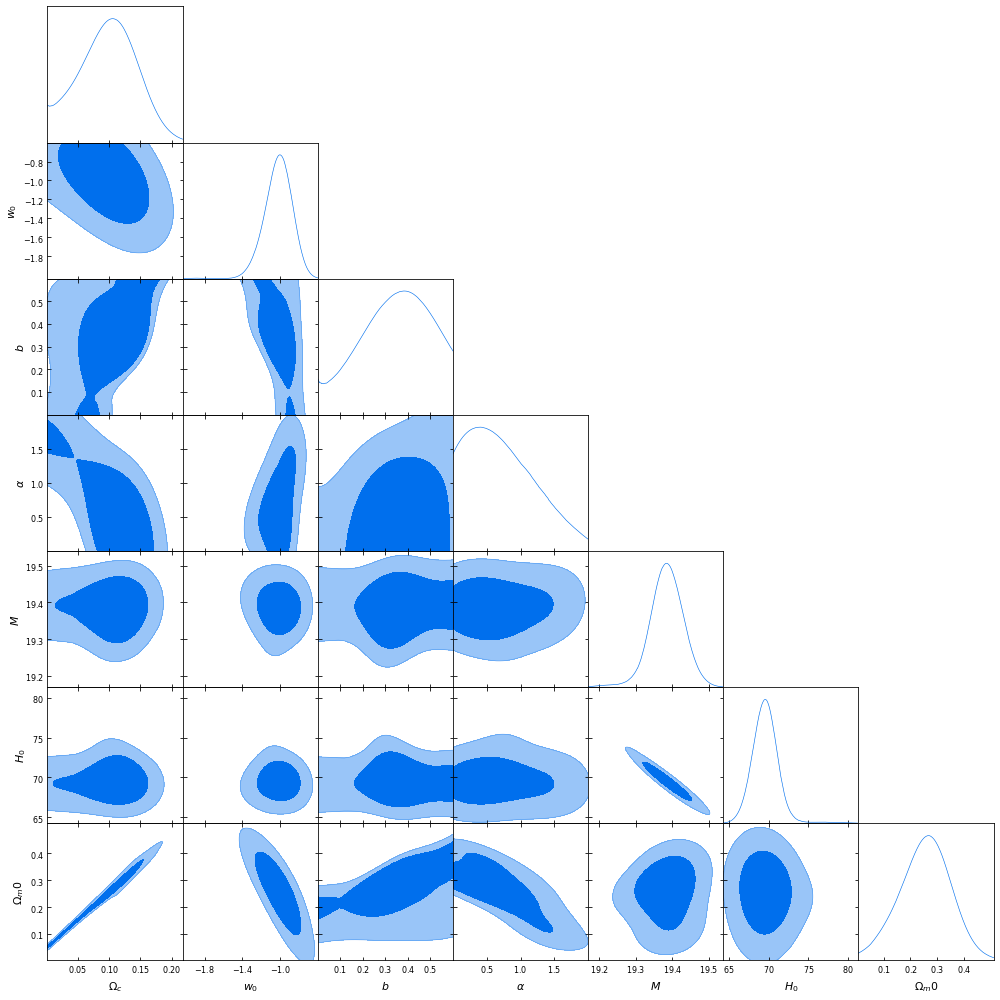

In [13]:
# Export the direct results to GetDist
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])
gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["oc0h2","ob0h2","w0","b","alpha", "M", "H0", "om0"], filled=True)
gdplot.export("bao-b.pdf")

In [17]:

import numpy as np # Export the results from chain file to GetDist
a = np.loadtxt('./chains31/gaus.1.txt')

np.savetxt('./xxx/xxx.txt',a[:,0:9])

param = np.array([['oc0h2','\Omega_c'],['w0','w0'],['b','b'],['alpha','alpha'],['M','M'],['H0','H0'],['om0','om0']])
np.savetxt('./xxx/xxx.paramnames',param,fmt='%s')

prior = np.array([('oc0h2',0.,1.4),('w0',-3.0,-0.01),('b',0.0,0.5),('alpha',0.0,2.0),('M',15.,25.),('H0',55.,85.)],
                 dtype=[('n','U10'),('1','f8'),('2','f8')])
np.savetxt('./xxx/xxx.ranges',prior,fmt='   '.join(['%s']+['%1.3f']+['%1.3f']))

[root] *WARNING* 2D kernel density bandwidth optimizer failed for oc0h2, om0. Using fallback width: f(a) and f(b) must have different signs
[root] *WARNING* 2D kernel density bandwidth optimizer failed for w0, b. Using fallback width: f(a) and f(b) must have different signs
[root] *WARNING* 2D kernel density bandwidth optimizer failed for w0, alpha. Using fallback width: f(a) and f(b) must have different signs
[root] *WARNING* 2D kernel density bandwidth optimizer failed for b, om0. Using fallback width: f(a) and f(b) must have different signs
[root] *WARNING* 2D kernel density bandwidth optimizer failed for alpha, om0. Using fallback width: f(a) and f(b) must have different signs


<Figure size 432x324 with 0 Axes>

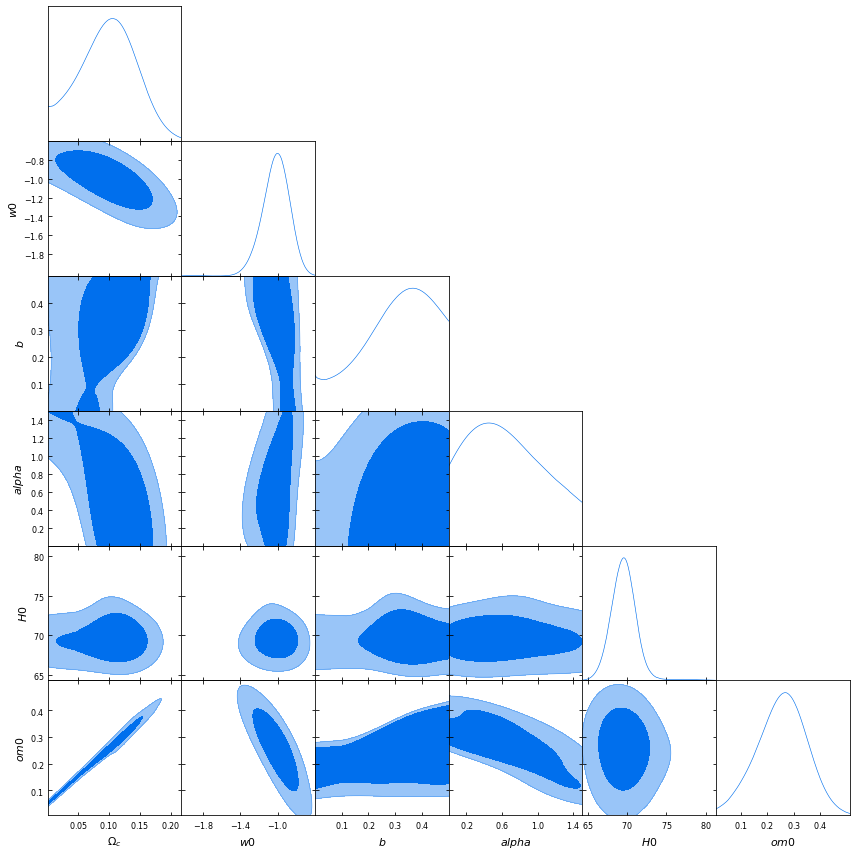

In [28]:
# Export the direct results to GetDist
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt
from getdist.mcsamples import MCSamplesFromCobaya
from getdist.mcsamples import MCSamples
from getdist.chains    import Chains
import getdist.plots as gdplt
from getdist import plots
from getdist import loadMCSamples

gd_samples =  loadMCSamples('./xxx/xxx')
gdplot = gdplt.get_subplot_plotter()
g = plots.get_single_plotter()
gdplot.triangle_plot(gd_samples, ["oc0h2","w0","b","alpha", "H0", "om0"], filled=True)
#gdplot.export("22a.pdf")
#g.plot_2d(samples, 'om0', 'w0', filled=True)

In [19]:
print(gd_samples.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\Omega_c       $} & $0.100^{+0.069}_{-0.089}   $\\

{\boldmath$w0             $} & $-1.02^{+0.28}_{-0.29}     $\\

{\boldmath$b              $} & ---                         \\

{\boldmath$alpha          $} & $< 1.60                    $\\

{\boldmath$M              $} & $19.385^{+0.084}_{-0.084}  $\\

{\boldmath$H0             $} & $69.6^{+3.1}_{-3.3}        $\\

{\boldmath$om0            $} & $0.26^{+0.18}_{-0.20}      $\\
\hline
\end{tabular}


In [29]:
stats = gd_samples.getMargeStats()
lims0 = stats.parWithName('oc0h2').limits
lims1 = stats.parWithName('w0').limits
lims2 = stats.parWithName('b').limits
lims3 = stats.parWithName('alpha').limits
lims4 = stats.parWithName('om0').limits

for conf, lim0, lim1, lim2, lim3, lim4 in zip(gd_samples.contours,lims0, lims1, lims2, lims3, lims4):
    print('oc0h2 %s%% lower: %.3f upper: %.3f (%s)'%(conf, lim0.lower, lim0.upper, lim0.limitType()))
    print('w0 %s%% lower: %.3f upper: %.3f (%s)'%(conf, lim1.lower, lim1.upper, lim1.limitType()))
    print('b %s%% lower: %.3f upper: %.3f (%s)'%(conf, lim2.lower, lim2.upper, lim2.limitType()))
    print('alpha %s%% lower: %.3f upper: %.3f (%s)'%(conf, lim3.lower, lim3.upper, lim3.limitType()))
    print('om0 %s%% lower: %.3f upper: %.3f (%s)'%(conf, lim4.lower, lim4.upper, lim4.limitType()))

oc0h2 0.68% lower: 0.055 upper: 0.148 (two tail)
w0 0.68% lower: -1.149 upper: -0.864 (two tail)
b 0.68% lower: 0.221 upper: 0.528 (two tail)
alpha 0.68% lower: 0.037 upper: 0.981 (two tail)
om0 0.68% lower: 0.167 upper: 0.357 (two tail)
oc0h2 0.95% lower: 0.011 upper: 0.169 (two tail)
w0 0.95% lower: -1.314 upper: -0.741 (two tail)
b 0.95% lower: 0.000 upper: 0.500 (none)
alpha 0.95% lower: 0.000 upper: 1.596 (one tail upper limit)
om0 0.95% lower: 0.060 upper: 0.436 (two tail)
oc0h2 0.99% lower: 0.000 upper: 0.179 (one tail upper limit)
w0 0.99% lower: -1.434 upper: -0.655 (two tail)
b 0.99% lower: 0.000 upper: 0.500 (none)
alpha 0.99% lower: 0.000 upper: 1.500 (none)
om0 0.99% lower: 0.057 upper: 0.439 (two tail)


In [25]:

import numpy as np # Export the results from chain file to GetDist
a = np.loadtxt('./chains31/gaus.1.txt')

np.savetxt('./xxx/xxx.txt',a[:,0:9])

param = np.array([['oc0h2','\Omega_c'],['w0','w0'],['b','b'],['alpha','alpha'],['M','M'],['H0','H0'],['om0','om0'],])
np.savetxt('./xxx/xxx.paramnames',param,fmt='%s')

prior = np.array([('oc0h2',0.,1.4),('w0',-2.5,-0.01),('b',0.0,0.5),('alpha',0.0,1.5),('M',15.,25.),('H0',55.,85.)],
                 dtype=[('n','U10'),('1','f8'),('2','f8')])
np.savetxt('./xxx/xxx.ranges',prior,fmt='   '.join(['%s']+['%1.3f']+['%1.3f']))

In [26]:
# Export the direct results to GetDist
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt
from getdist.mcsamples import MCSamplesFromCobaya
from getdist.mcsamples import MCSamples
from getdist.chains    import Chains
import getdist.plots as gdplt
from getdist import plots
from getdist import loadMCSamples

gd_samples =  loadMCSamples('./xxx/xxx')
gdplot = gdplt.get_subplot_plotter()
g = plots.get_single_plotter()
#gdplot.triangle_plot(gd_samples, ["oc0h2","w0","b","alpha", "M", "H0", "om0"], filled=True)
#gdplot.export("22a.pdf")
#g.plot_2d(samples, 'om0', 'w0', filled=True)

[root] *WARNING* outlier fraction 0.0019345238095238096 


<Figure size 432x324 with 0 Axes>

In [27]:
print(gd_samples.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\Omega_c       $} & $0.100^{+0.069}_{-0.089}   $\\

{\boldmath$w0             $} & $-1.02^{+0.28}_{-0.29}     $\\

{\boldmath$b              $} & ---                         \\

{\boldmath$alpha          $} & $< 1.60                    $\\

{\boldmath$M              $} & $19.385^{+0.084}_{-0.084}  $\\

{\boldmath$H0             $} & $69.6^{+3.1}_{-3.3}        $\\

{\boldmath$om0            $} & $0.26^{+0.18}_{-0.20}      $\\
\hline
\end{tabular}
